In [5]:
import argparse
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt


# Setup

In [38]:
#? Setup Linear Regression Class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=10)
        )

    def forward(self, x):
        x  = self.features(x)
        x = self.classifier(x)
        return x

# Train & Test Code

In [40]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for img, labels in loader:
        img = img.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    return running_loss / total, 100.0 * correct / total

def test(model, loader, criterion, device):
    model.eval()
    loss_sum = 0
    correct = 0
    total = 0

    for img, labels in loader:
        img = img.to(device)
        labels = labels.to(device)

        outputs = model(img)
        loss = criterion(outputs, labels)

        loss_sum += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    return loss_sum / total, 100.0 * correct / total



# CIFAR10

## Setup Params

In [45]:
batch_size = 128
learning_rate = 1e-4
weight_decay = 1e-4
epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA or CPU:", device)

CUDA or CPU: cuda


## Setup Data & Model

In [7]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10("datasets", train=True, download=True, transform=transforms)
test_dataset = datasets.CIFAR10("datasets", train=True, download=True, transform=transforms)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [46]:
 # 28x28 img and 10 classes
optimizer_options = ["Adam", "SGDNesterov", "AdaGrad"]
result_list = []

for optimizer_name in optimizer_options:
    print("Optimizer: ", optimizer_name)
    model = ConvNet().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGDNesterov":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9, nesterov=True)
    elif optimizer_name == "AdaGrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        print(f"Warning: Optimizer {optimizer_name} not a condition. Skipping")
        continue

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    start_time = time.time()
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%"
        )

    end_time = time.time()
    result_list.append([optimizer_name, test_loss_list, test_acc_list, end_time - start_time])

print("training complete")


Optimizer:  Adam
Epoch 1/25 | Train Loss: 1.7677 | Train Acc: 34.53% | Test Loss: 1.5563 | Test Acc: 42.98%
Epoch 2/25 | Train Loss: 1.4568 | Train Acc: 47.09% | Test Loss: 1.3605 | Test Acc: 50.51%
Epoch 3/25 | Train Loss: 1.3238 | Train Acc: 52.29% | Test Loss: 1.2473 | Test Acc: 55.74%
Epoch 4/25 | Train Loss: 1.2316 | Train Acc: 56.02% | Test Loss: 1.1699 | Test Acc: 58.75%
Epoch 5/25 | Train Loss: 1.1541 | Train Acc: 58.94% | Test Loss: 1.0925 | Test Acc: 61.91%
Epoch 6/25 | Train Loss: 1.0892 | Train Acc: 61.48% | Test Loss: 1.0408 | Test Acc: 63.24%
Epoch 7/25 | Train Loss: 1.0355 | Train Acc: 63.69% | Test Loss: 1.0030 | Test Acc: 64.65%
Epoch 8/25 | Train Loss: 0.9887 | Train Acc: 65.38% | Test Loss: 0.9712 | Test Acc: 65.98%
Epoch 9/25 | Train Loss: 0.9452 | Train Acc: 66.87% | Test Loss: 0.9218 | Test Acc: 67.97%
Epoch 10/25 | Train Loss: 0.9084 | Train Acc: 68.14% | Test Loss: 0.8623 | Test Acc: 70.09%
Epoch 11/25 | Train Loss: 0.8769 | Train Acc: 69.55% | Test Loss: 0.8625

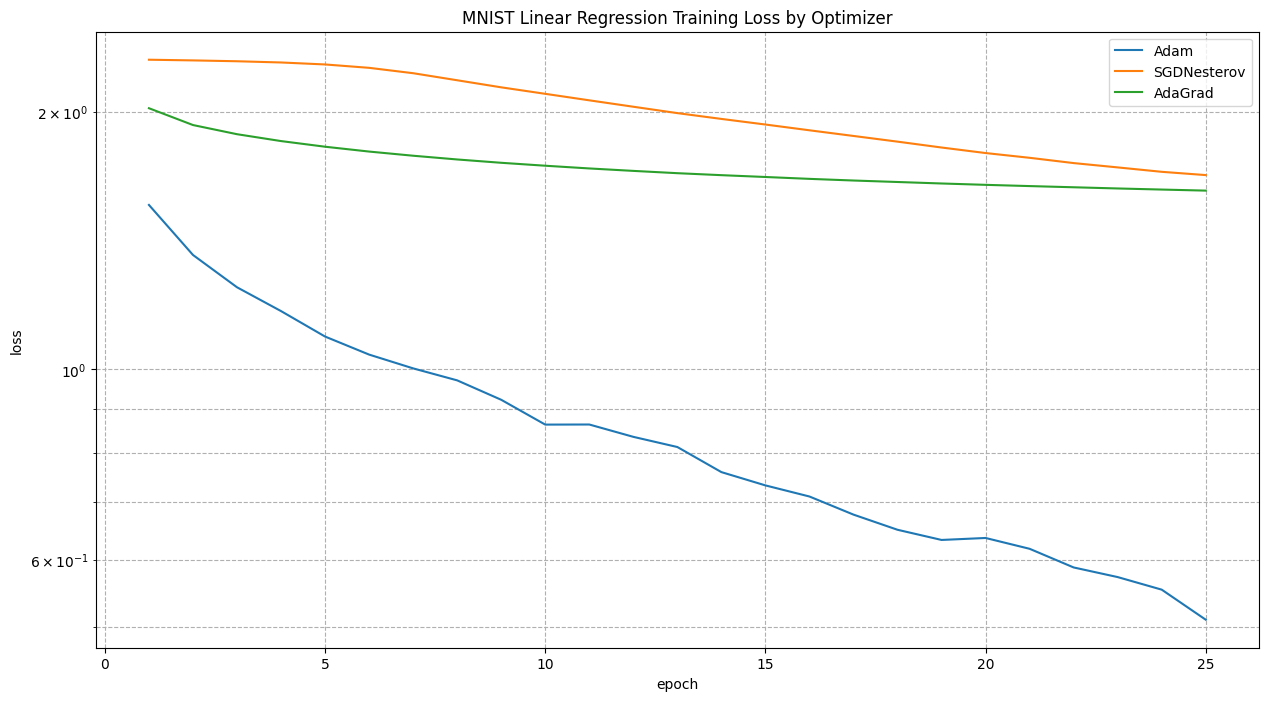

In [47]:

plt.figure(figsize=(15, 8))
for result in result_list:
    plt.plot(range(1,epochs+1), result[1], label=result[0])

plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.title("MNIST Linear Regression Training Loss by Optimizer")
plt.grid(True, which="both", ls="--")
plt.legend()
# Render the plot
plt.show()

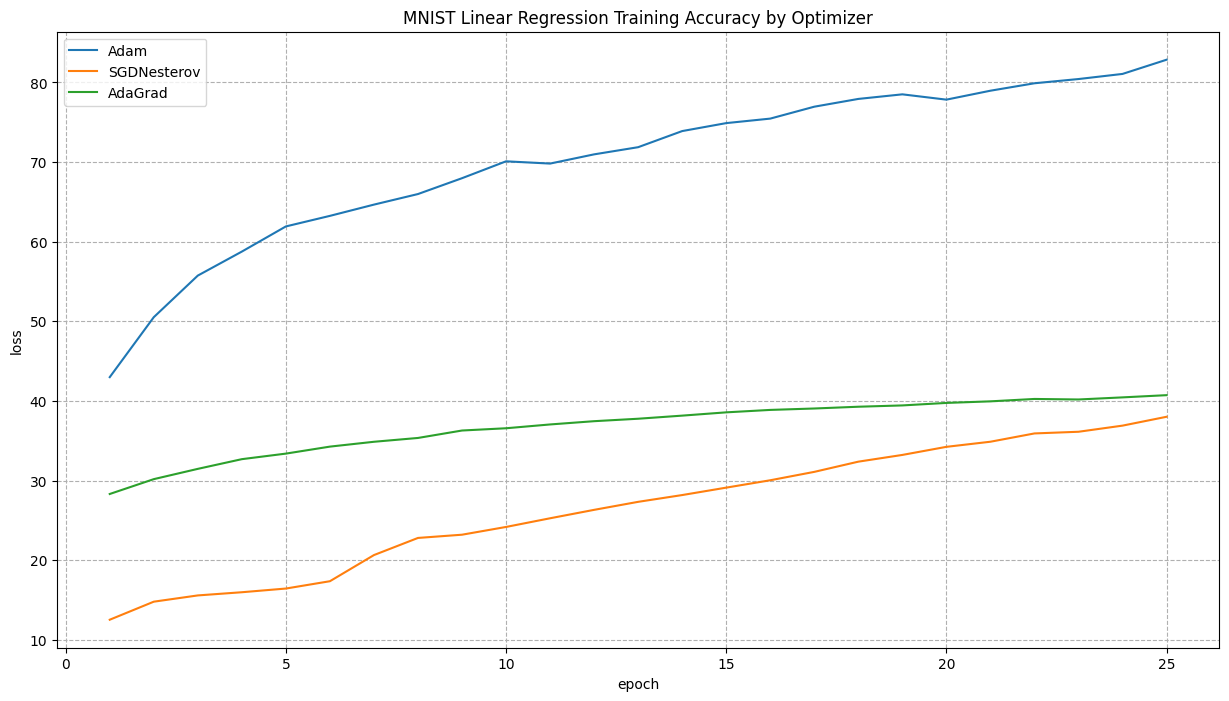

In [48]:

plt.figure(figsize=(15, 8))
for result in result_list:
    plt.plot(range(1,epochs+1), result[2], label=result[0])

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("MNIST Linear Regression Training Accuracy by Optimizer")
plt.grid(True, which="both", ls="--")
plt.legend()
# Render the plot
plt.show()

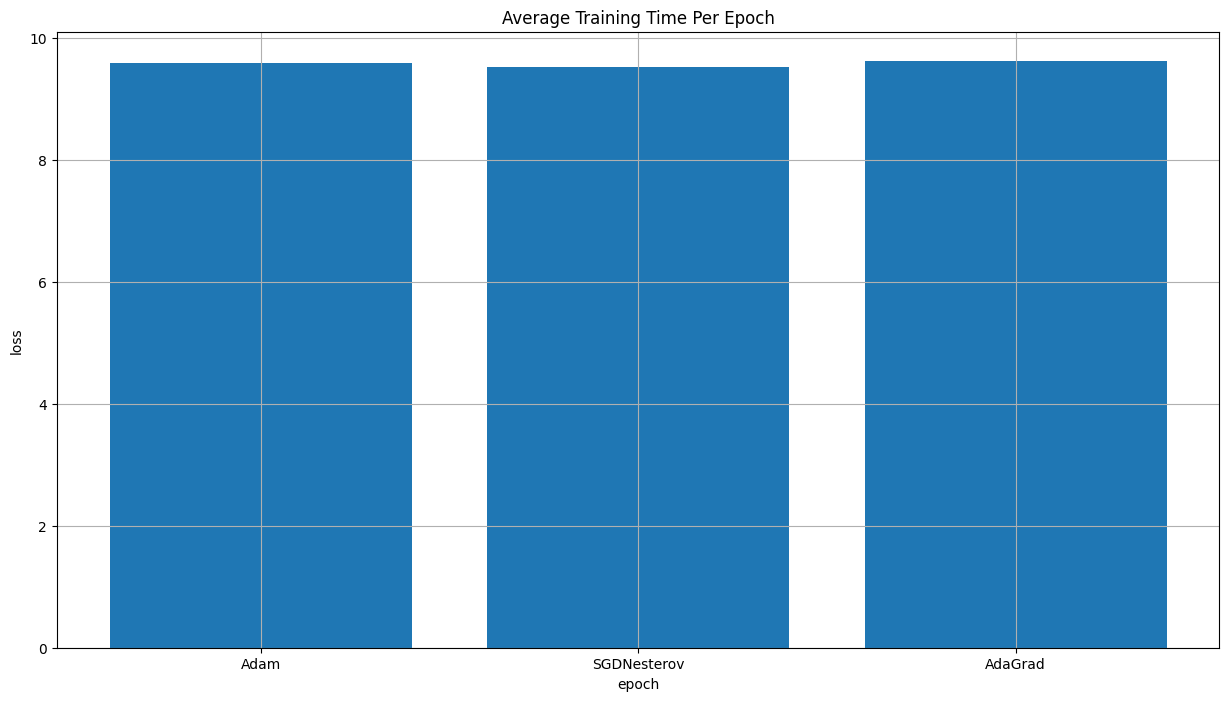

In [49]:
plt.figure(figsize=(15, 8))
x = []
y = []
for result in result_list:
    x.append(result[0])
    y.append(result[3]/epochs)

plt.bar(x,y)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Average Training Time Per Epoch")
plt.grid(True, which="both")
# Render the plot
plt.show()